In [41]:
import os
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)


In [34]:
gc.collect()

227

In [35]:
# Read Files 
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
structures = pd.read_csv('structures.csv')
contrib = pd.read_csv('scalar_coupling_contributions.csv')

In [36]:
contrib['sd_pso_dso'] =  contrib.apply(lambda x: x['sd'] + x['dso'] + x['pso'], axis=1)

In [37]:
contrib.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso,sd_pso_dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010,1.785209
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600,-0.222232
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870,-0.222406
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930,-0.222446
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013,1.785208


In [38]:
df = df.merge(contrib[['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'sd_pso_dso']], how = 'left', on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [39]:
df[['scalar_coupling_constant','sd_pso_dso']].corr(method='pearson')

,scalar_coupling_constant,sd_pso_dso
scalar_coupling_constant,1.000000,0.774614
sd_pso_dso,0.774614,1.000000


In [42]:
df[['sd_pso_dso']].describe()

,sd_pso_dso
count,4658147.000
mean,0.224
std,0.684
min,-5.071
25%,-0.087
50%,0.037
75%,0.210
max,5.080


In [5]:
df = df[(df.type == '1JHC')]
df_test = df_test[df_test.type == '1JHC']

In [6]:
def prepare_structures(structures):

        # Caluculate electronegativity and radius for atoms in structures
        atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

        fudge_factor = 0.05
        atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
        print(atomic_radius)

        electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

        #structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

        atoms = structures['atom'].values
        atoms_en = [electronegativity[x] for x in tqdm(atoms)]
        atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

        structures['EN'] = atoms_en
        structures['rad'] = atoms_rad

        display(structures.head())

        #Chemical Bond Calculation
        i_atom = structures['atom_index'].values
        p = structures[['x', 'y', 'z']].values
        p_compare = p
        m = structures['molecule_name'].values
        m_compare = m
        r = structures['rad'].values
        r_compare = r

        source_row = np.arange(len(structures))
        max_atoms = 28

        bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
        bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

        print('Calculating bonds')

        for i in tqdm(range(max_atoms-1)):
            p_compare = np.roll(p_compare, -1, axis=0)
            m_compare = np.roll(m_compare, -1, axis=0)
            r_compare = np.roll(r_compare, -1, axis=0)

            mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
            dists = np.linalg.norm(p - p_compare, axis=1) * mask
            r_bond = r + r_compare

            bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

            source_row = source_row
            target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
            target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row

            source_atom = i_atom
            target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
            target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col

            bonds[(source_row, target_atom)] = bond
            bonds[(target_row, source_atom)] = bond
            bond_dists[(source_row, target_atom)] = dists
            bond_dists[(target_row, source_atom)] = dists

        bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
        bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
        bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
        bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

        print('Counting and condensing bonds')

        bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
        bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
        bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
        bond_lengths_std = [ np.std(x) for x in bond_lengths]
        n_bonds = [len(x) for x in bonds_numeric]

        #bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
        #bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

        bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean,'bond_lengths_std':bond_lengths_std }
        bond_df = pd.DataFrame(bond_data)
        structures = structures.join(bond_df)
        display(structures.head(20))


In [7]:
# Map atom info from structures
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df


In [8]:
# def create_dist_features(df):
#     df['dist_to_type_mean'] = df['dist'] / df.groupby('type')['dist'].transform('mean')
#     df['dist_to_type_sd'] = df['dist'] / df.groupby('type')['dist'].transform('std')
#     df['dist_to_type_min'] = df['dist'] / df.groupby('type')['dist'].transform('min')
#     df['dist_to_type_max'] = df['dist'] / df.groupby('type')['dist'].transform('max')
    
#     df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
#     df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
#     df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
#     df['molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    
#     df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
#     df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
#     df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
#     df['molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')


#     return(df)


In [9]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    #df = reduce_mem_usage(df)
    return df

In [10]:
def angle(v1, v2, acute):
# v1 is your firsr vector
# v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle
    else:
        return 2 * np.pi - angle
    
def calculate_atom_angle(df):
    angle_list = list()
    for i in range(df.shape[0]):
        v1 = list(df[["x_0", "y_0", "z_0"]].iloc[i,])
        v2 = list(df[["x_1", "y_1", "z_1"]].iloc[i,])
        out = angle(v1, v2, True)
        angle_list.append(out)
        
        #print(f"Row {i} is done")
        
    return angle_list

def calc_angle(df):
    df["Angle"] = angle(df["coord_0"], df["coord_1"], True)
    
    return df

In [11]:
#Map structures data
df_train = map_atom_info(df, 0)
df_train = map_atom_info(df_train, 1)
df_test = map_atom_info(df_test, 0)
df_test = map_atom_info(df_test, 1)

In [12]:
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001
4,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,H,-0.027803,2.198949,0.014154,C,-0.013324,1.132466,0.008276


In [10]:
# Count number of atoms of specific type within molecule by type

y = df_train[['molecule_name', 'type', 'atom_index_0', 'atom_0']].rename(columns={'atom_index_0': 'atom_index', 'atom_0' : 'atom'})
x = df_train[['molecule_name', 'type', 'atom_index_1', 'atom_1']].rename(columns={'atom_index_1': 'atom_index', 'atom_1' : 'atom'})
xy = pd.concat([y,x])
xy_by_atom = xy.groupby(['molecule_name', 'type', 'atom_index','atom']).count().reset_index()
xy_by_atom = pd.pivot_table(xy_by_atom, values='atom_index', index=['molecule_name', 'type'], columns=['atom'])
df_train_trial = df_train.merge(xy_by_atom, on = ['molecule_name', 'type'])

df_train_trial[['scalar_coupling_constant','H']].corr(method='pearson')

,scalar_coupling_constant,H
scalar_coupling_constant,1.00000,-0.29258
H,-0.29258,1.00000


In [11]:
# Count number of atoms within molecule by type
y = df_train[['molecule_name', 'type', 'atom_index_0', 'atom_0']].rename(columns={'atom_index_0': 'atom_index', 'atom_0' : 'atom'})
x = df_train[['molecule_name', 'type', 'atom_index_1', 'atom_1']].rename(columns={'atom_index_1': 'atom_index', 'atom_1' : 'atom'})
xy = pd.concat([y,x])
xy_agg = xy.groupby(['molecule_name', 'type', 'atom_index','atom']).count().reset_index()
xy_agg = xy_agg.groupby(['molecule_name', 'type'])['atom_index'].count().reset_index().rename(columns = {'atom_index':'atom_count'})
df_train_trial = df_train.merge(xy_agg, on = ['molecule_name', 'type'])

df_train_trial[['scalar_coupling_constant','atom_count']].corr(method='pearson')

,scalar_coupling_constant,atom_count
scalar_coupling_constant,1.000000,-0.300652
atom_count,-0.300652,1.000000


In [12]:
df_train[f'numebr_of_bonds_molecule_type'] = df_train.groupby(['molecule_name', 'type'])['id'].transform('count')

In [13]:
x = df_train.groupby(['molecule_name', 'type', 'atom_index_0', 'atom_0'])['id'].count()
y = df_train.groupby(['molecule_name', 'type', 'atom_index_1', 'atom_1'])['id'].count()

In [14]:
x = pd.DataFrame(x).reset_index()

In [15]:
x.head()

,molecule_name,type,atom_index_0,atom_0,id
0,dsgdb9nsd_000001,1JHC,1,H,1
1,dsgdb9nsd_000001,1JHC,2,H,1
2,dsgdb9nsd_000001,1JHC,3,H,1
3,dsgdb9nsd_000001,1JHC,4,H,1
4,dsgdb9nsd_000005,1JHC,2,H,1


In [16]:
test = df_train.groupby(['molecule_name', 'type'])['atom_index_0'].nunique()
#df_train[f'atom_1_unique_type_count'] = df_train.groupby(['molecule_name', 'type'])['atom_index_1'].nunique()

In [17]:
test = pd.DataFrame(test).reset_index()

In [18]:
test = test.rename(columns={'atom_index_0': 'atom_0_unique_type_count'})

In [19]:
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,numebr_of_bonds_molecule_type
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,4
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,4
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,4
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,4
4,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,H,-0.027803,2.198949,0.014154,C,-0.013324,1.132466,0.008276,1


In [20]:
df_train = df_train.merge(test, on = ["molecule_name", "type"])

In [21]:
df_train[['scalar_coupling_constant','atom_0_unique_type_count']].corr(method='pearson')

,scalar_coupling_constant,atom_0_unique_type_count
scalar_coupling_constant,1.000000,-0.336058
atom_0_unique_type_count,-0.336058,1.000000


In [22]:
test.head()

,molecule_name,type,atom_0_unique_type_count
0,dsgdb9nsd_000001,1JHC,4
1,dsgdb9nsd_000005,1JHC,1
2,dsgdb9nsd_000007,1JHC,6
3,dsgdb9nsd_000008,1JHC,3
4,dsgdb9nsd_000009,1JHC,4


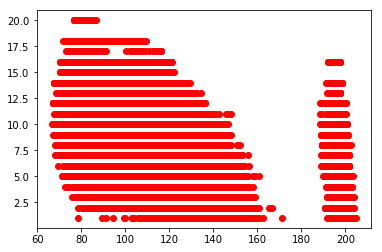

In [23]:
plt.plot(df_train.scalar_coupling_constant, df_train.numebr_of_bonds_molecule_type, 'ro')

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


,molecule_name,atom_index,atom,x,y,z,EN,rad
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43


In [297]:
# Calculate distance between atoms
train_p_0 = df_train[['x_0', 'y_0', 'z_0']].values
train_p_1 = df_train[['x_1', 'y_1', 'z_1']].values
test_p_0 = df_test[['x_0', 'y_0', 'z_0']].values
test_p_1 = df_test[['x_1', 'y_1', 'z_1']].values

df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
df_train['dist_x'] = (df_train['x_0'] - df_train['x_1']) ** 2
df_test['dist_x'] = (df_test['x_0'] - df_test['x_1']) ** 2
df_train['dist_y'] = (df_train['y_0'] - df_train['y_1']) ** 2
df_test['dist_y'] = (df_test['y_0'] - df_test['y_1']) ** 2
df_train['dist_z'] = (df_train['z_0'] - df_train['z_1']) ** 2
df_test['dist_z'] = (df_test['z_0'] - df_test['z_1']) ** 2

In [298]:
df_train['Angle']  = [np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) for v1,v2 in zip(train_p_0, train_p_1)]

In [301]:
df_train['type_0'] = df_train['type'].apply(lambda x: x[0])
df_test['type_0'] = df_test['type'].apply(lambda x: x[0])

In [10]:
#df_train['type_0'] = df_train['type'].apply(lambda x: x[0])
#df_test['type_0'] = df_test['type'].apply(lambda x: x[0])

In [ ]:
#df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# df_train['dist_to_type_mean'] = df_train['dist'] / df_train.groupby('type')['dist'].transform('mean')
# df_train['dist_to_type_sd'] = df_train['dist'] / df_train.groupby('type')['dist'].transform(np.std)

#df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
# df_test['dist_to_type_mean'] = df_test['dist'] / df_test.groupby('type')['dist'].transform('mean')
# df_test['dist_to_type_sd'] = df_test['dist'] / df_test.groupby('type')['dist'].transform(np.std)

In [302]:
# df_train = create_dist_features(df_train)
# df_test = create_dist_features(df_test)

df_train = create_features(df_train)
df_test = create_features(df_test)

In [52]:
#df_train.to_feather('df_train.feather')
#df_test.to_feather('df_test.feather')

In [303]:
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,type_0,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,1,0.000003,-1.091950,1.091950,-0.000003,0.999997,1.091953,1.091946,0.000003,-1.091950
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,1,0.000003,-1.091948,1.091950,-0.000002,0.999998,1.091953,1.091946,0.000003,-1.091948
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,...,1,0.000003,-1.091943,1.091950,0.000003,1.000003,1.091953,1.091946,0.000003,-1.091943
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,...,1,0.000003,-1.091944,1.091950,0.000002,1.000002,1.091953,1.091946,0.000003,-1.091944
4,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,H,-0.027803,2.198949,0.014154,...,1,NaN,NaN,1.066598,0.000000,1.000000,1.066598,1.066598,NaN,NaN


In [88]:
df_train.shape

(4658147, 72)

In [304]:
# Encode Categorical Variables
for f in ['type_0', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[f].values) + list(df_train[f].values))
    df_train[f] = lbl.transform(list(df_train[f].values))
    df_test[f] = lbl.transform(list(df_test[f].values))

In [56]:
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)

In [305]:
# Drop unnecessary columns
#df_train = df_train.sample(frac = 0.01)
X = df_train.drop(['id', 'molecule_name', 'scalar_coupling_constant', 'type'], axis=1)
Y = df_train['scalar_coupling_constant']
X_test = df_test.drop(['id', 'molecule_name'], axis=1)

In [306]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(types).mean()
    totlog = np.log(maes)
    return totlog.mean()

In [307]:
# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)

In [308]:
### Train the Model
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'n_estimators': 5000,
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [312]:
scores = []
for i, (train_index, test_index) in enumerate(kf.split(df_train)):

        # Create data for this fold
        Y_train, Y_valid = Y.iloc[train_index].copy(), Y.iloc[test_index].copy()
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        
        print( f'\nFold: {i}')

        fit_model = lgb.LGBMRegressor(**params)
        fit_model.fit(X_train, Y_train)
        pred = fit_model.predict(X_valid)
        # Save validation predictions for this fold
        print( "Group Log MAE: ", math.log(mean_absolute_error(Y_valid, pred)))
        scores.append(math.log(mean_absolute_error(Y_valid, pred)))
        
print(f'The mean score of a model for is: {np.mean(scores)}')


Fold: 0
Group Log MAE:  1.0132405457071325

Fold: 1


KeyboardInterrupt: 

In [ ]:
def show_varimp(fit_model):
        feature_imp = pd.DataFrame(sorted(zip(fit_model.feature_importances_,X.columns)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features')
        plt.tight_layout()
        plt.show()
        plt.savefig('lgbm_importances-01.png')

In [ ]:
show_varimp(fit_model)

In [174]:
#fit_model = lgb.LGBMRegressor(**params)
#fit_model.fit(X, Y)

LGBMRegressor(bagging_seed=11, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=10, metric='mae', min_child_samples=79,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=200, objective='regression',
       random_state=None, reg_alpha=0.1302650970728192,
       reg_lambda=0.3603427518866501, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1, verbosity=-1)

In [175]:
#pred = fit_model.predict(X)
#print( "Group Log MAE: ", group_mean_log_mae(Y, pred, X['type']))

Group Log MAE:  0.04906399812874684


In [ ]:
# Hyper parameter optimization 

# param_grid = {
#     'learning_rate': [0.001, 0.005, 0.1],
#     'n_estimators': [500, 1000]
# }

# gbm = GridSearchCV(estimator, param_grid, cv=10, return_train_score = True)
# gbm.fit(X_train, Y_train, eval_metric='mae')

# print('Best parameters found by grid search are:', gbm.best_params_)

In [102]:
### Submission ###
submit_pred = fit_model.predict(X_test)
submit_pred= pd.DataFrame(submit_pred)
submit_pred.columns = ['scalar_coupling_constant']
 
sub = pd.concat([df_test['id'], submit_pred], axis = 1)
 
sub.to_csv('submission_basic.csv', index  = False)